In [36]:
#Import Mask RCNN packages
import mrcnn.model as modellib
from mrcnn.visualize import random_colors, patches, apply_mask, find_contours, Polygon

#Import OrgaSegment functions
from lib import get_image_names, mask_projection, config_to_dict
import importlib

#Import other packages
import tensorflow as tf
import sys
import shutil
from skimage.io import imread, imsave
from skimage.color import label2rgb, gray2rgb 
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
from keras.preprocessing.image import load_img

%matplotlib inline 

In [64]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, show=True):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    show: To show the plot image on exection. If False the plot image will be returned.
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    
#     ax.imshow(masked_image.astype(np.uint8))
#     if auto_show:
#         plt.show()
    return ax, masked_image.astype(np.uint8)

In [2]:
#Get config
config_path='./conf/OrganoidApoptosisConfig20230315.py'
spec = importlib.util.spec_from_file_location('PredictConfig', config_path)
modulevar = importlib.util.module_from_spec(spec)
spec.loader.exec_module(modulevar)
config = modulevar.PredictConfig()

In [3]:
#inputs
input_dir = '/hpc/umc_beekman/data_organoids/20230228_SNIPPERT-MAARTEN/'
if os.path.isdir(input_dir) == False:
    print(f'Incorrect input path specified: {input_dir}')
    exit(1)
else:
    input_dir=os.path.join(input_dir, '')
    print(f'Input dir: {input_dir}')
    output_dir=os.path.join(input_dir, config.MODEL_NAME, '')
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    print(f'Output dir: {output_dir}')
    preview_dir=os.path.join(input_dir, config.MODEL_NAME, 'preview', '')
    Path(preview_dir).mkdir(parents=True, exist_ok=True)
    print(f'Preview dir: {preview_dir}')

Input dir: /hpc/umc_beekman/data_organoids/20230228_SNIPPERT-MAARTEN/
Output dir: /hpc/umc_beekman/data_organoids/20230228_SNIPPERT-MAARTEN/organoid-apoptosis20230315T1410/
Preview dir: /hpc/umc_beekman/data_organoids/20230228_SNIPPERT-MAARTEN/organoid-apoptosis20230315T1410/preview/


In [4]:
#Get data
    print('Get image names')
    images = get_image_names(input_dir, '_masks')

    #Load model
    print('Loading model')
    model = modellib.MaskRCNN(mode='inference', 
                              config=config,
                              model_dir=config.MODEL_DIR)
    model.load_weights(config.MODEL, by_name=True)

    #Load classes for preview
    classes_preview = config.CLASSES
    classes_preview.insert(0, 'BG')

    #Create empty data frame for results
    results =  pd.DataFrame({'image': pd.Series([], dtype='str'),
                            'mask': pd.Series([], dtype='str'),
                            'name': pd.Series([], dtype='str'),
                            'id': pd.Series([], dtype=np.int16),
                            'y1':  pd.Series([], dtype=np.int16),
                            'x1': pd.Series([], dtype=np.int16), 
                            'y2': pd.Series([], dtype=np.int16), 
                            'x2': pd.Series([], dtype=np.int16),
                            'class': pd.Series([], dtype=np.int16),
                            'score':  pd.Series([], dtype=np.float32),
                            'size': pd.Series([], dtype=np.int16)})

Get image names
Loading model







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 500


In [5]:
i = images[0]

image_name = re.search(f'^{input_dir}(.*)\..*$', i).group(1)

#Load image
img = np.asarray(load_img(i, color_mode=config.COLOR_MODE))
if np.amax(img) < 255:
    print('Orginal image is 8 bit')
else:
    print('Converting image to a full range 8 bit image')
    img = ((img - np.amax(img)) * 255).astype('uint8')

if config.COLOR_MODE == 'grayscale':
    img = img[..., np.newaxis]

#Predict organoids
pred = model.detect([img], verbose=1)
p = pred[0]

Orginal image is 8 bit
Processing 1 images
image                    shape: (2208, 2208, 1)       min:    1.00000  max:  254.00000  uint8
molded_images            shape: (1, 2240, 2240, 1)    min:    0.00000  max:  254.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2240.00000  int64
anchors                  shape: (1, 1253175, 4)       min:   -0.08085  max:    1.05226  float32


Class ids: [1 1 1 1 2 1 1 2 1 1 2 1 2 1 1 1 2 1 2 1 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 3 2
 1 1 2 3 3 2 3 2 3 2 2 3 1 1 2 1 2 3 2 1 1 2 1 1 1 2 2 1 2 3 1 1 1 1 1 3 1
 2 1 3 3 3 2 2 1]
Class names: ['BG', 'alive', 'dead', 'intermediate']


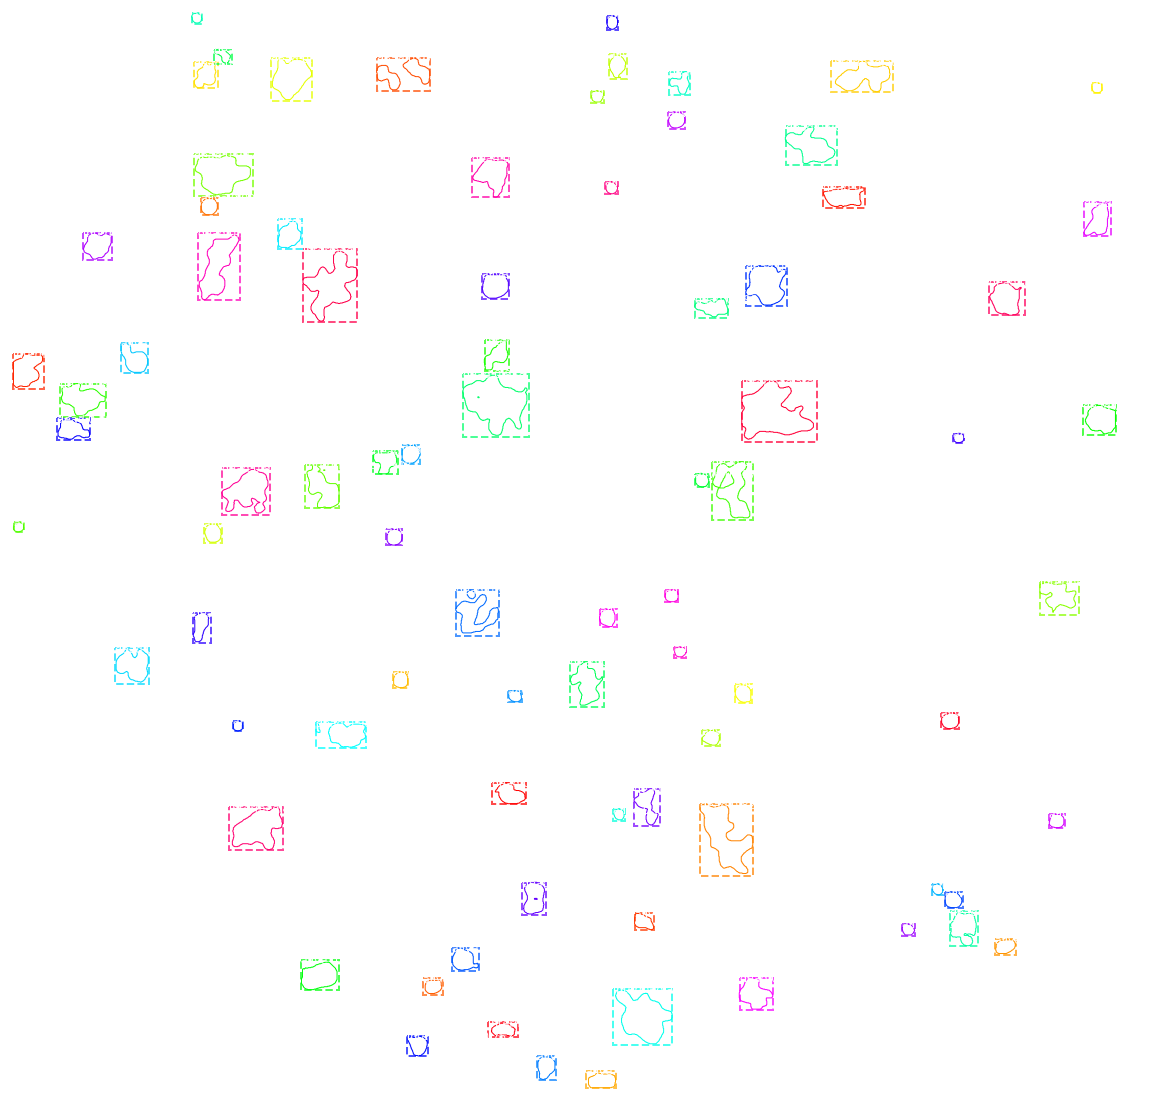

In [65]:
#Save a preview
preview_name = f'{image_name}_preview.png'
preview_path = preview_dir + preview_name

img_preview = np.asarray(load_img(i, color_mode='rgb'))

print(f'Class ids: {p["class_ids"]}')
print(f'Class names: {classes_preview}')

ax, preview = display_instances(img_preview, p['rois'], 
                  p['masks'], p['class_ids'], 
                                      classes_preview, p['scores'], figsize=(20,20))

In [72]:
import matplotlib.pyplot as plt
a = ax.imshow(preview)

In [75]:
help(a)

Help on AxesImage in module matplotlib.image object:

class AxesImage(_ImageBase)
 |  An image attached to an Axes.
 |  
 |  Parameters
 |  ----------
 |  ax : `~.axes.Axes`
 |      The axes the image will belong to.
 |  cmap : str or `~matplotlib.colors.Colormap`, default: :rc:`image.cmap`
 |      The Colormap instance or registered colormap name used to map scalar
 |      data to colors.
 |  norm : `~matplotlib.colors.Normalize`
 |      Maps luminance to 0-1.
 |  interpolation : str, default: :rc:`image.interpolation`
 |      Supported values are 'none', 'antialiased', 'nearest', 'bilinear',
 |      'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite',
 |      'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell',
 |      'sinc', 'lanczos'.
 |  origin : {'upper', 'lower'}, default: :rc:`image.origin`
 |      Place the [0, 0] index of the array in the upper left or lower left
 |      corner of the axes. The convention 'upper' is typically used for
 |      matri

In [79]:
b = a.get_figure()
help

original_image           shape: (1024, 1024, 3)       min:   24.00000  max:  206.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (53,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (53, 4)               min:   31.00000  max:  938.00000  int32
gt_mask                  shape: (1024, 1024, 53)      min:    0.00000  max:    1.00000  bool


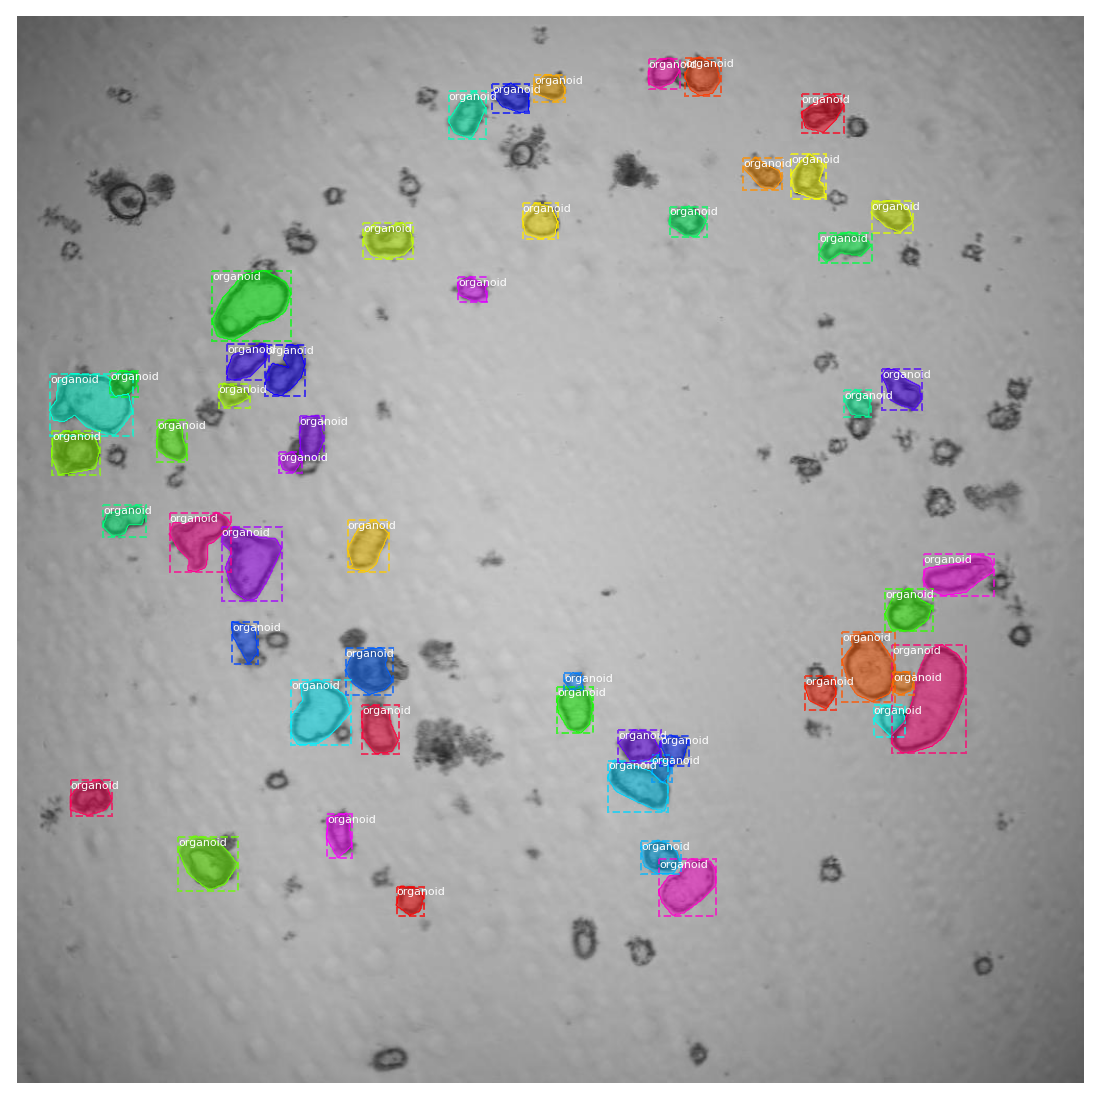

In [8]:
# Test on a random image
image_id = random.choice(data_eval.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(data_eval, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            data_train.class_names, figsize=(20, 20))

In [ ]:
list(set(gt_class_id))
myindices = [i for i, u in enumerate(gt_class_id) if u == 1]
gt_mask
[gt_mask[i] for i in myindices]

In [10]:
image_id = 0
# Load image and ground truth data
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(data_eval, inference_config,
                           image_id, use_mini_mask=False)
molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
# Run object detection
results = model.detect([image], verbose=0)
r = results[0]
# Compute AP
# AP, precisions, recalls, overlaps =\
#     utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                      r["rois"], r["class_ids"], r["scores"], r['masks'])

In [55]:
def mask_projection(mask_3D):
    """
    Create projection (2 dimensions) of masks with dimensions 3
    @params:
      mask_3D::[numpy.array] - Numpy array with 3 dimensions (y, x, mask)
    @returns:
      mask::[numpy.array] - Numpy array with 2 dimenstion (y, x). Where 0=No masks and > 0 are masks.
    """
    #Create new empty mask
    mask =  np.zeros((mask_3D.shape[0], mask_3D.shape[1]), np.int8)

    #Process predictions
    for count, l in enumerate(range(mask_3D.shape[2])):
        #Get mask information
        msk = mask_3D[:,:,l].astype(np.int8)
        num = l + 1
        msk = np.where(msk != 0, num, msk)
        if count == 0:
            mask = msk
        else:
            mask = np.maximum(mask, msk) #Combine previous mask with new mask
    
    return mask

In [60]:
for class_id in list(set(gt_class_id)):
    #Get gt per class id
    gt_indices = [i for i, u in enumerate(gt_class_id) if u == class_id] #get gt indices where label is equal to i
    gt = [gt_mask[:,:,i] for i in gt_indices] #get gt masks where label is equal to i
    gt = mask_projection(np.stack(gt, axis=-1))

    #Get prediction per class id
    p_indices = [i for i, u in enumerate(r['class_ids']) if u == class_id] #get prediction indices where label is equal to i
    scores = [r['scores'][i] for i in p_indices] #get scores where label is equal to i
    p_masks = [r['masks'][:,:,i] for i in p_indices] #get prediction masks where label is equal to i

    #Remove masks with a low score
    threshold = 0.9
    s_indices = [i for i, u in enumerate(scores) if u >= threshold] #get prediction indices where score is higher than thresholds
    p = [p_masks[i] for i in s_indices] #get prediction masks where score is higher than threshold
    p = mask_projection(np.stack(p, axis=-1))

In [79]:
import cellpose
ap, tp, fp, fn = cellpose.metrics.average_precision(gt, p, np.arange(0.5, 1.05, 0.05))

In [80]:
ap

array([0.6666667 , 0.6666667 , 0.6666667 , 0.6666667 , 0.61290324,
       0.5873016 , 0.5625    , 0.31578946, 0.08695652, 0.        ,
       0.        ], dtype=float32)

In [ ]:
p[0]
# np.zeros(p[0].shape, np.int8)